# Web Map Services (WMS) for GemGIS

This Notebook is demonstrating how Web Map Services can be used with GemGIS. 

**What is a Web Map Service?**
A Web Map Service (WMS) is a standard protocol developed by the Open Geospatial Consortium in 1999 for serving georeferenced map images over the Internet. These images are typically produced by a map server from data provided by a GIS database. (https://en.wikipedia.org/wiki/Web_Map_Service)

This means that map data is stored on a server but we can still access and utilize it. 

The library ```OWSLib``` will be used to retrieve the data from the serves. A link to the GeoPython Webpage is provided here: https://geopython.github.io/OWSLib/.
The library can easily be installed via Anaconda prompt executing ```conda install -c conda-forge owslib``` or using ```pip```. It is not dependent on GDAL.


In [2]:
%pip install owslib

  Using cached OWSLib-0.19.2-py2.py3-none-any.whl (197 kB)
Note: you may need to restart the kernel to use updated packages.


# Import Libraries

In [235]:
from owslib.wms import WebMapService
import io
import matplotlib.pyplot as plt
import numpy as np

# Loading the WebMapService

The WebMapServices can be loaded with ```load_wms```. By default, the service of Terrestris is selected. A custom link can be provided as kwarg. A ```owslib.map.wms111.WebMapService_1_1_1``` object will be returned.

In [81]:
def load_wms(**kwargs) -> owslib.map.wms111.WebMapService_1_1_1:
    """
    Loading the Web Map Service
    Args:
        
    Kwargs: 
        path: alternative file path for Web Map Service
    Returns:
        wms: owslib.map.wms111.WebMapService_1_1_1
     """
    
    path = kwargs.get('path','https://ows.terrestris.de/osm/service?' )
    
    wms = WebMapService(path)
    
    return wms

In [82]:
wms = load_wms()

# Get WebMapService Properties

Properties of the ```owslib.map.wms111.WebMapService_1_1_1``` object can easily be retrieved in the following way.

## Service Metadata

In [85]:
wms.identification.type

'OGC:WMS'

In [10]:
wms.identification.version

'1.1.1'

In [11]:
wms.identification.title

'OpenStreetMap WMS'

In [12]:
wms.identification.abstract

'OpenStreetMap WMS, bereitgestellt durch terrestris GmbH und Co. KG. Beschleunigt mit MapProxy (http://mapproxy.org/)'

## Available Layers

In [292]:
list(wms.contents)

['OSM-WMS',
 'OSM-Overlay-WMS',
 'TOPO-WMS',
 'TOPO-OSM-WMS',
 'SRTM30-Hillshade',
 'SRTM30-Colored',
 'SRTM30-Colored-Hillshade',
 'SRTM30-Contour']

## Details of a Layer

In [14]:
wms['OSM-WMS'].title

'OpenStreetMap WMS - by terrestris'

In [15]:
wms['OSM-WMS'].queryable

1

In [16]:
wms['OSM-WMS'].opaque

0

In [93]:
 wms['OSM-WMS'].boundingBox

(-20037508.3428, -25819498.5135, 20037508.3428, 25819498.5135, 'EPSG:900913')

In [ ]:
wms['OSM-WMS'].boundingBox

In [18]:
wms['OSM-WMS'].boundingBoxWGS84

(-180.0, -88.0, 180.0, 88.0)

In [19]:
wms['OSM-WMS'].crsOptions

['EPSG:25833',
 'EPSG:31467',
 'EPSG:4647',
 'EPSG:2056',
 'EPSG:900913',
 'EPSG:5243',
 'EPSG:4686',
 'EPSG:3068',
 'EPSG:31463',
 'EPSG:2100',
 'EPSG:29192',
 'EPSG:31468',
 'EPSG:25832',
 'EPSG:4258',
 'EPSG:31466',
 'EPSG:21781',
 'EPSG:2180',
 'EPSG:3857',
 'EPSG:4839',
 'EPSG:32648',
 'EPSG:3034',
 'EPSG:4674',
 'EPSG:4326',
 'EPSG:29193',
 'EPSG:3035']

In [20]:
wms['OSM-WMS'].styles

{'default': {'title': 'default',
  'legend': 'http://ows.terrestris.de/osm/service?styles=&layer=OSM-WMS&service=WMS&format=image%2Fpng&sld_version=1.1.0&request=GetLegendGraphic&version=1.1.1'}}

## Available Methods, their URLs and available formats

In [21]:
[op.name for op in wms.operations]

['GetCapabilities', 'GetMap', 'GetFeatureInfo', 'GetLegendGraphic']

In [22]:
wms.getOperationByName('GetMap').methods

[{'type': 'Get', 'url': 'http://ows.terrestris.de/osm/service?'}]

In [23]:
wms.getOperationByName('GetMap').formatOptions

['image/jpeg', 'image/png']

## Imagery Request

Request an Image from the WebMapService and save it as Numpy Array. The default image loaded is located over North Rhine Westfalia, Germany in WGS84. Extent, size and more properties can be changed by providing kwargs to the function ```request_image_as_array```.

In [251]:
def request_image_as_array(wms, **kwargs) -> owslib.util.ResponseWrapper:
    """
    Request imagery and convert into numpy array 
    Args:
        wms: owslib.map.wms111.WebMapService_1_1_1
    Kwargs: 
        layers list - List of content layer names 
        styles: list - Optional list of named styles, must be the same length as the layers list
        srs: string - A spatial reference system identifier.
        extent: tuple - (left, bottom, right, top) in srs units, can be the same as for GemPy
        size: tuple - (width, height) in pixels.
        format: string - Output image format such as 'image/jpeg'.
        transparent: bool - Optional. Transparent background if True.
        
    Returns:
        image: numpy.ndarray
    """
        
    layers = kwargs.get('layers', [list(wms.contents)[0]])
    
    style = [(key, wms[list(wms.contents)[0]].styles[key]) for key in wms[list(wms.contents)[0]].styles][0][0]
    styles = kwargs.get('styles', [style])
    srs = kwargs.get('srs', 'EPSG:4326')
    extent = kwargs.get('extent', (5, 48, 10, 53))
    size = kwargs.get('size', (2000,2000))
    form = kwargs.get('format', wms.getOperationByName('GetMap').formatOptions[1])
    transparent = kwargs.get('transparent', True)
    
    img = wms.getmap(layers=layers,
                    styles=styles,
                    srs=srs,
                    bbox=extent,
                    size=size,
                    format=form,
                    transparent=True)
    
    img = io.BytesIO(img.read())
    image = plt.imread(img)
    image = np.flipud(image)
    return image

## Plotting with default settings

In [262]:
img = request_image_as_array(wms)

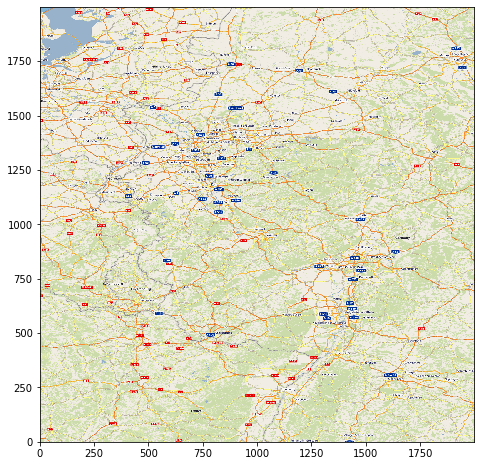

In [253]:
fig = plt.figure(figsize=(8,8))

plt.imshow(img, origin="lower")

plt.show()

## Plotting the "Aachen Area"

The "Aachen Area" was requested and plotted below. The resolution of each cell is 100 m. 

In [268]:
minx = 32286000
maxx = 32328000
miny = 5620000
maxy = 5648000

img = request_image_as_array(wms, srs = 'EPSG:4647', extent = (minx,miny,maxx,maxy), size = (int((maxx-minx)/10),int((maxy-miny)/10)))

(2800, 4200, 3)


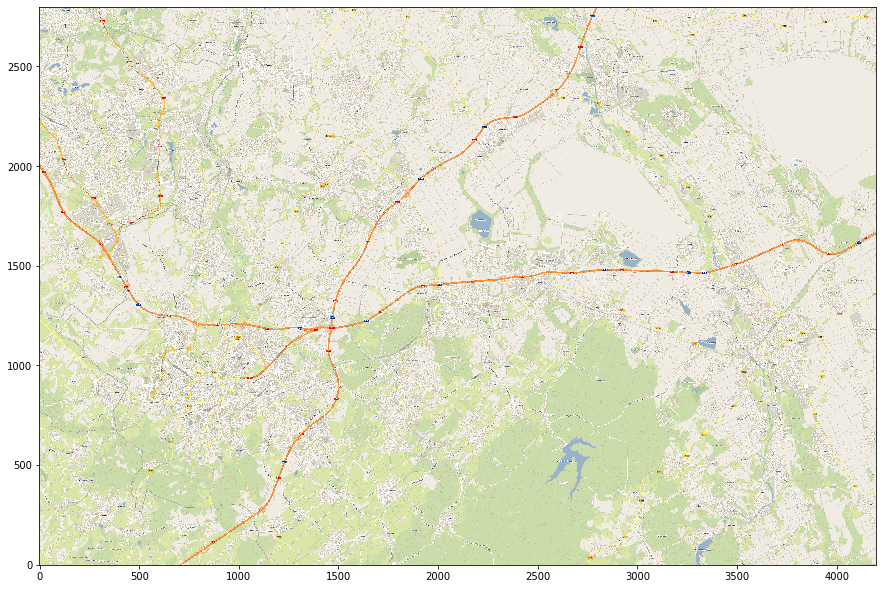

In [270]:
fig = plt.figure(figsize=(15,15))
print(img.shape)
plt.imshow(img, origin="lower")

plt.show()

## Plotting a subset of the array including random points (e.g. wells)

(2800, 4200, 3)


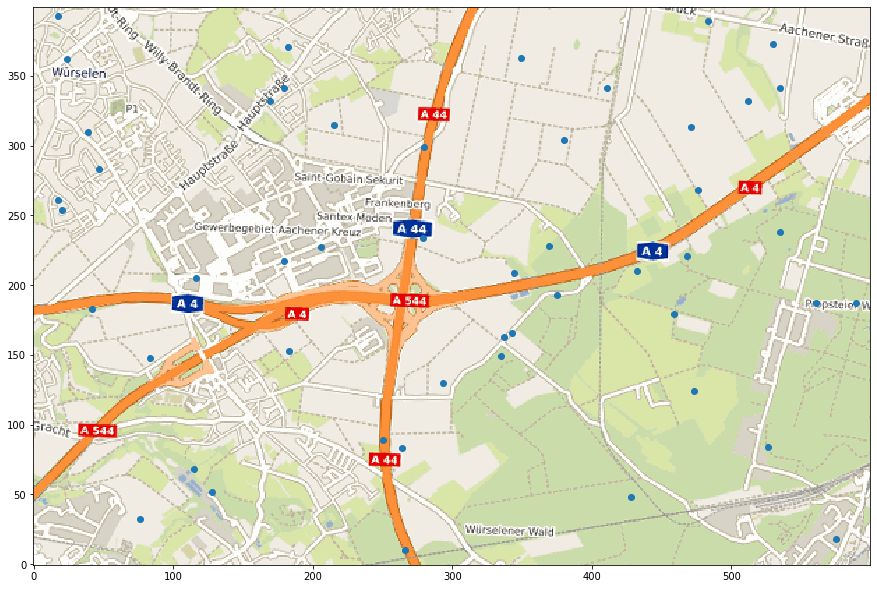

In [291]:
fig = plt.figure(figsize=(15,15))
print(img.shape)
plt.imshow(img[1000:1400,1200:1800], origin="lower")
plt.scatter(np.random.randint(0,600,50), np.random.randint(0,400,50))
plt.show()

## Plotting different WMS Layers

In [293]:
list(wms.contents)

['OSM-WMS',
 'OSM-Overlay-WMS',
 'TOPO-WMS',
 'TOPO-OSM-WMS',
 'SRTM30-Hillshade',
 'SRTM30-Colored',
 'SRTM30-Colored-Hillshade',
 'SRTM30-Contour']

### Plotting Topography

In [301]:
minx = 32286000
maxx = 32328000
miny = 5620000
maxy = 5648000

img = request_image_as_array(wms, layers = ['TOPO-OSM-WMS'], srs = 'EPSG:4647', extent = (minx,miny,maxx,maxy), size = (int((maxx-minx)/10),int((maxy-miny)/10)))

(2800, 4200, 4)


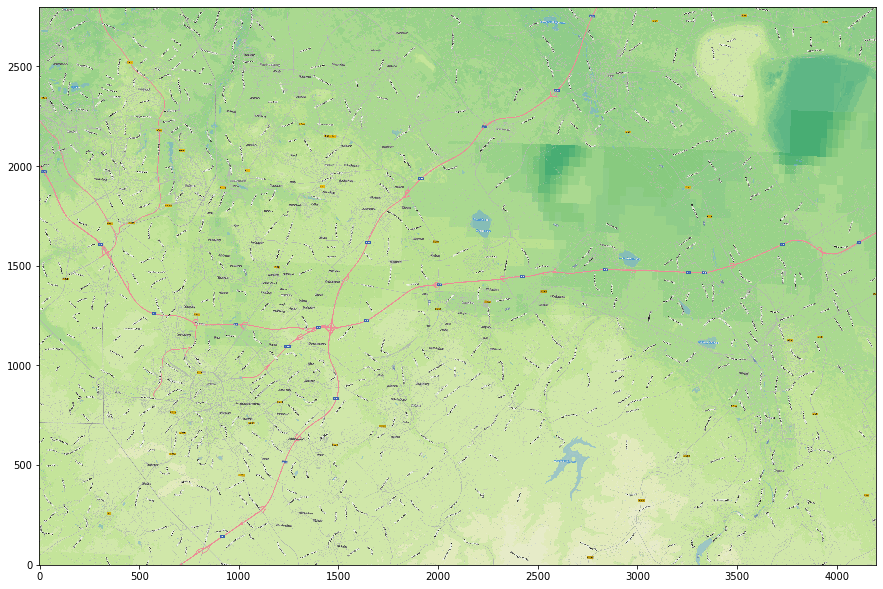

In [302]:
fig = plt.figure(figsize=(15,15))
print(img.shape)
plt.imshow(img, origin="lower")

plt.show()

(2800, 4200, 4)


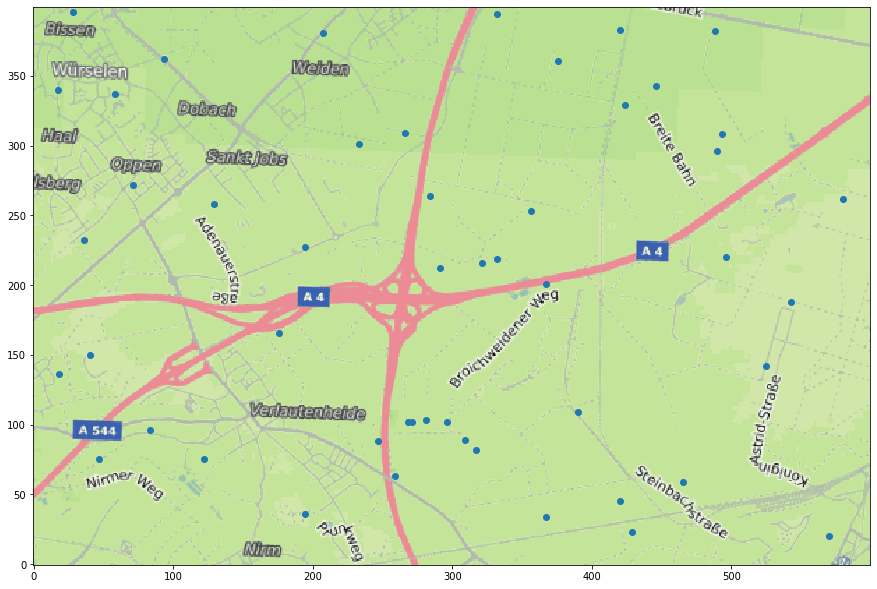

In [303]:
fig = plt.figure(figsize=(15,15))
print(img.shape)
plt.imshow(img[1000:1400,1200:1800], origin="lower")
plt.scatter(np.random.randint(0,600,50), np.random.randint(0,400,50))
plt.show()

### Plotting Hillshades

In [304]:
minx = 32286000
maxx = 32328000
miny = 5620000
maxy = 5648000

img = request_image_as_array(wms, layers = ['SRTM30-Colored-Hillshade'], srs = 'EPSG:4647', extent = (minx,miny,maxx,maxy), size = (int((maxx-minx)/10),int((maxy-miny)/10)))

(2800, 4200, 4)


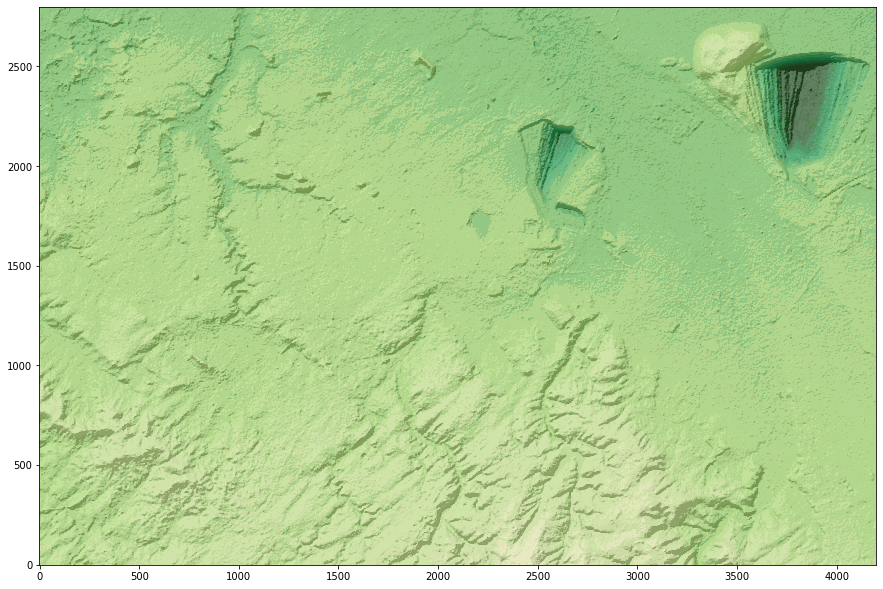

In [305]:
fig = plt.figure(figsize=(15,15))
print(img.shape)
plt.imshow(img, origin="lower")

plt.show()

(2800, 4200, 4)


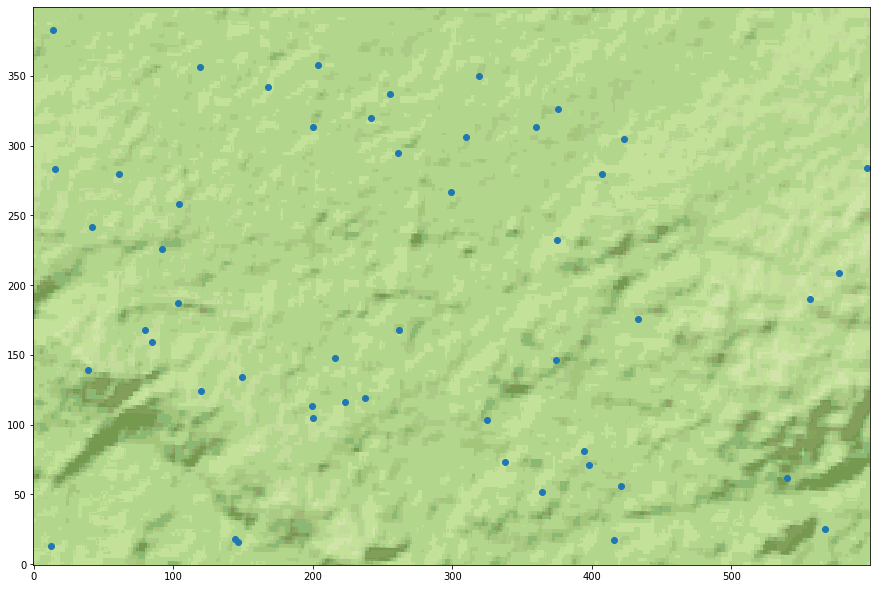

In [307]:
fig = plt.figure(figsize=(15,15))
print(img.shape)
plt.imshow(img[1000:1400,1200:1800], origin="lower")
plt.scatter(np.random.randint(0,600,50), np.random.randint(0,400,50))
plt.show()